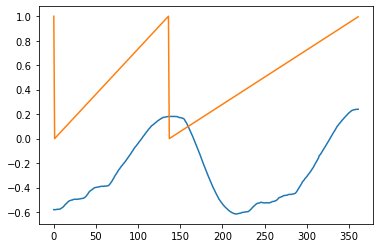

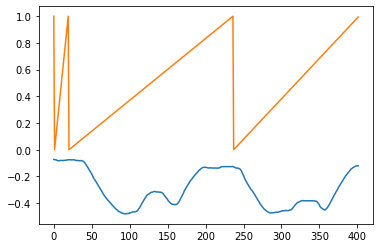

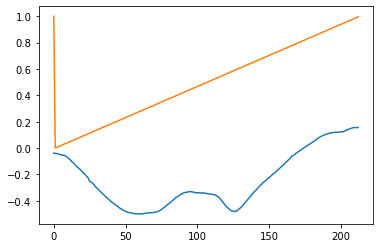

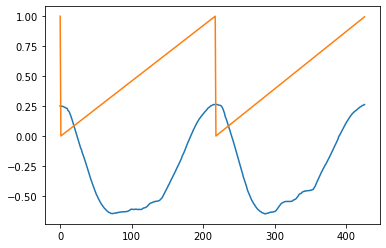

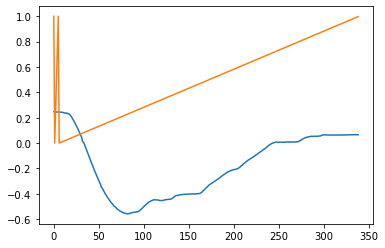

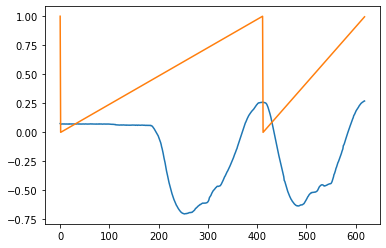

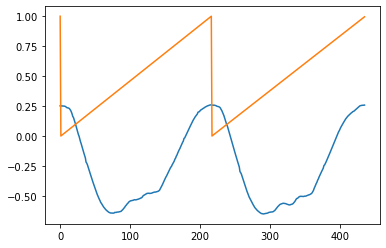

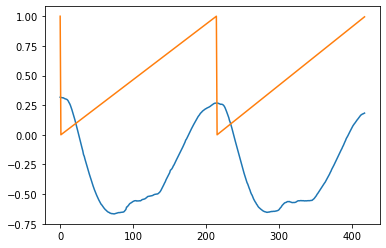

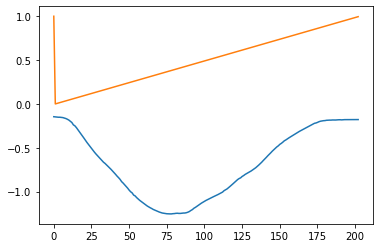

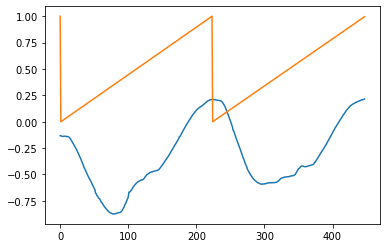

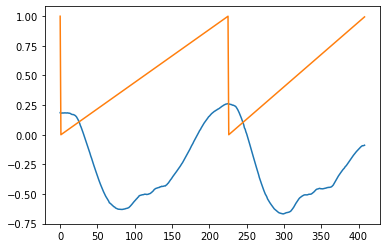

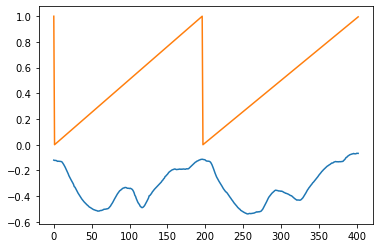

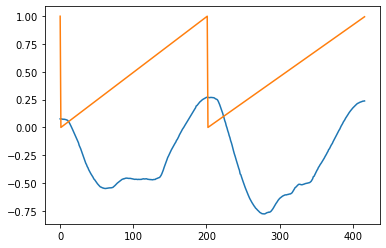

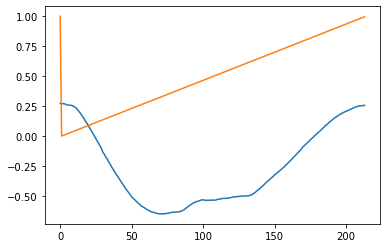

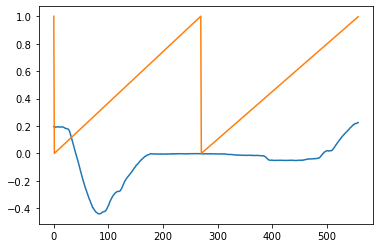

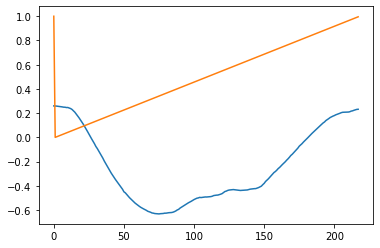

In [241]:
import numpy as np
import pandas as pd
import glob
import keras
from scipy.signal import find_peaks, peak_prominences, peak_widths
import matplotlib.pyplot as plt

columns = ['lJPos', 'rJPos', 'lJVel', 'rJVel', 'lJTorque', 'rJTorque',
           'eulerX', 'eulerY', 'eulerZ', 'gyroX', 'gyroY', 'gyroZ', 'accX', 'accY', 'accZ',
           'batt', 'cpu', 'mem', 'lBttn', 'rBttn', 'time', 'lJVelFilt', 'rJVelFilt',
           'lJPosReset', 'rJPosReset', 'lGC', 'rGC', 'stand', 'lCmdTorque', 'rCmdTorque',
           'lRecvTorque', 'rRecvTorque', 'lStanceSwing', 'rStanceSwing', 'nWalk', 'lWalk', 'rWalk', 'none']
channel = ['lJPos', 'rJPos', 'lJVel', 'rJVel', 'gyroX', 'gyroY', 'gyroZ', 'accX', 'accY', 'accZ']

for file_path in glob.glob(f'data/raw/AB01_CW_ZI.txt'):
    data = pd.read_csv(file_path, sep=" ", header=None)
    data.columns = columns
    input_data = pd.DataFrame(data, columns=channel).to_numpy()
    
def find_peak_idx(joint_positions):
    peaks, _ = find_peaks(joint_positions)
    prominences = peak_prominences(joint_positions, peaks)[0]
    maximas, _ = find_peaks(joint_positions, prominence=np.median(prominences)+np.var(prominences), distance=150)
    return maximas

def label_ground_truth(joint_positions):
    maximas = find_peak_idx(joint_positions)
    maximas = np.append(0, maximas)
    end_idx = maximas[-1]
    
    y = pd.Series(np.nan, index=range(0, joint_positions.shape[0]))  
    for maxima in maximas:
        y[maxima] = 1
        y[maxima+1] = 0
    y.interpolate(inplace=True)
    y.fillna(0, inplace=True)
    y_theta = y * 2 * np.pi
    
    cartesian_output = np.stack([np.cos(y_theta), np.sin(y_theta)], axis=1)
    return y, end_idx, cartesian_output

model = keras.models.load_model('User_INDEP_WS120.h5')

channel_number = 10
buffer_size = 600

old_buffer = np.empty((0, channel_number))
current_buffer = np.empty((0, channel_number))

for ii, stream_vec in enumerate(input_data[10000:20000,:]):
    stream_vec = np.expand_dims(stream_vec, axis=0)
    current_buffer = np.concatenate([current_buffer, stream_vec], axis=0)
    
#     if current_buffer.shape[0] == 120:
#         test = np.expand_dims(current_buffer, axis=0)
#         print(model.predict(test))
        
    if current_buffer.shape[0] == buffer_size:
        peak_idx = find_peak_idx(current_buffer[:,0])[-1]
        x = np.concatenate([old_buffer, current_buffer[:peak_idx, :]], axis=0)
        gait_phase, end_idx, y = label_ground_truth(x[:,0])
        x = x[:end_idx,:]
        y = y[:end_idx,:]
        gait_phase = gait_phase[:end_idx]
        
        plt.plot(x[:,0])
        plt.plot(gait_phase)
        plt.show()
        y = np.concatenate([y, y], axis=1)
        
        old_buffer = current_buffer[peak_idx:, :]
        current_buffer = np.empty((0, channel_number))
        
        
